### 运行版本

In [1]:
import sys

sys.version

'3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import tensorflow

tensorflow.__version__

'2.6.0'

In [3]:
import torch

torch.__version__

'1.10.1'

In [4]:
# !python -m deepxde.backend.set_default_backend tensorflow.compat.v1

In [5]:
import deepxde

deepxde.__version__

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



'1.1.3'

# 2 拉普拉斯方程(Laplace's equation)

本节介绍Laplace方程的定义以及它的基本解。



## 2.1 基本定义

记 $\large x=(x_1,\cdots,x_n) \in \mathbb{R}^n, u=u(x), 拉普拉斯算子 \Delta u = \sum^n_{i=1} u_{x_i x_i} $，Laplace方程又称为“**位势方程**”, 最有用的PDE之一无疑。包括Laplace方程
$$
\large \Delta u = 0 \tag{2.1}
$$
以及Poisson方程
$$
\large - \Delta u = f.  \tag{2.2}
$$
在上面两个方程中，$x \in U$ 且未知量为 $\large u:\bar{U} \to \mathbb{R}, u = u(x)$，这里 $u \subset \mathbb{R}^n$ 是开集. 而在第二个方程中 $f:U \to \mathbb{R}$ 也是给定的。

**定义2.1[调和函数]** 假设$u \in C^2$ 且满足 $\Delta u = 0$，则称 $u$ 为调和函数。



## 2.2 基本解

基本解(fundamental solution)的来源: 研究PDE的一个好的方式是去找某个特解. 由于这个PDE是线性的, 所以可以用特解去找更复杂的解. 此外, 为了寻找显然的特解, 通常会把注意力集中在某类具有**对称性**的函数.

**定义2.2** 函数
$$
\large
\Phi(x) = 
\begin{cases}
\begin{aligned}
&-\frac{1}{2\pi} \ln|x|, & n=2\\
&\frac{1}{n(n-2)\alpha(n)}   \frac{1}{|x|^{n-2}}, & n\geq3\\
\end{aligned}
\end{cases}
(x \in \mathbb{R}^n, x \neq 0) \tag{2.3} \\
$$
叫做Laplace方程的**基本解**，这里 $\large \alpha(n) = \mathbb{R}^n中单位球的体积 = \frac{\sqrt{\pi^n}}{ \Gamma(\frac{n}{2}+1)}$。

## 代码来源
https://deepxde.readthedocs.io/en/latest/demos/laplace.disk.html

# 磁盘上的拉普拉斯方程
## 问题设置
我们将在极坐标系中求解拉普拉斯方程：

$$r\frac{dy}{dr}+r^2\frac{dy}{dr^2}+\frac{dy}{dθ^2}=0,r∈[0,1],θ∈[0,2π]$$
与狄利克雷边界条件

$$y(1,θ)=cos(θ)$$
和周期性边界条件

$$y(r,θ+2π)=y(r,θ).$$
参考解决方案是 $y=rcos(θ)$.

## 导入模块

In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## 定义PDE 问题

拉普拉斯方程：

$$r\frac{dy}{dr}+r^2\frac{dy}{dr^2}+\frac{dy}{dθ^2}=0,r∈[0,1],θ∈[0,2π]$$

In [2]:
def pde(x, y):
    dy_r = dde.grad.jacobian(y, x, i=0, j=0)
    dy_rr = dde.grad.hessian(y, x, i=0, j=0)
    dy_thetatheta = dde.grad.hessian(y, x, i=1, j=1)
    return x[:, 0:1] * dy_r + x[:, 0:1] ** 2 * dy_rr + dy_thetatheta

In [3]:
# Rectangle 𝑟∈[0,1],θ∈[0,2π]

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 2 * np.pi])

狄利克雷边界条件

$$y(1,θ)=cos(θ)$$
和周期性边界条件

$$y(r,θ+2π)=y(r,θ).$$

In [4]:
def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_rad = dde.DirichletBC(
    geom,
    lambda x: np.cos(x[:, 1:2]),
    lambda x, on_boundary: on_boundary and np.isclose(x[0], 1),
)

方程的解是 $y=rcos(θ)$.

In [5]:
def solution(x):
    r, theta = x[:, 0:1], x[:, 1:]
    return r * np.cos(theta)

定义PDE问题

In [6]:
data = dde.data.PDE(
    geom, pde, bc_rad, num_domain=2540, num_boundary=80, solution=solution
)

# 数字 2540 是在域内采样的训练残差点数，数字 80 是在边界上采样的训练点数。

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "


## 定义net

In [7]:
# 如果我们用笛卡尔坐标重写这个问题，变量的形式为[rsin(θ),rcos(θ)]. 
# 我们将它们用作特征来满足某些潜在的物理约束，从而使网络沿θ坐标，周期为2π.

def feature_transform(x):
    return tf.concat(
        [x[:, 0:1] * tf.sin(x[:, 1:2]), x[:, 0:1] * tf.cos(x[:, 1:2])], axis=1
    )

In [8]:
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

net.apply_feature_transform(feature_transform)

## 定义model

In [9]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-5, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.065929 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.666418 s



## model.train

In [10]:
losshistory, train_state = model.train(epochs=30000)

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [1.83e-03, 5.39e-01]    [1.83e-03, 5.39e-01]    [1.05e+00]    
1000      [1.68e-02, 1.36e-03]    [1.68e-02, 1.36e-03]    [3.43e-02]    
2000      [8.92e-03, 5.40e-04]    [8.92e-03, 5.40e-04]    [2.18e-02]    
3000      [4.38e-03, 2.25e-04]    [4.38e-03, 2.25e-04]    [1.48e-02]    
4000      [1.47e-03, 1.06e-04]    [1.47e-03, 1.06e-04]    [1.07e-02]    
5000      [1.41e-04, 5.86e-05]    [1.41e-04, 5.86e-05]    [7.85e-03]    
6000      [2.94e-05, 3.81e-05]    [2.94e-05, 3.81e-05]    [6.38e-03]    
7000      [2.37e-05, 2.72e-05]    [2.37e-05, 2.72e-05]    [5.46e-03]    
8000      [1.91e-05, 1.76e-05]    [1.91e-05, 1.76e-05]    [4.48e-03]    
9000      [1.56e-05, 1.02e-05]    [1.56e-05, 1.02e-05]    [3.51e-03]    
10000     [1.22e-05, 5.24e-06]    [1.22e-05, 5.24e-06]    [2.65e-03]    
11000     [8.82e-06, 2.42e-06]    [8.82e-06, 2.42e-06]    [1.97e-03]    
12000 

## 绘制图像

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

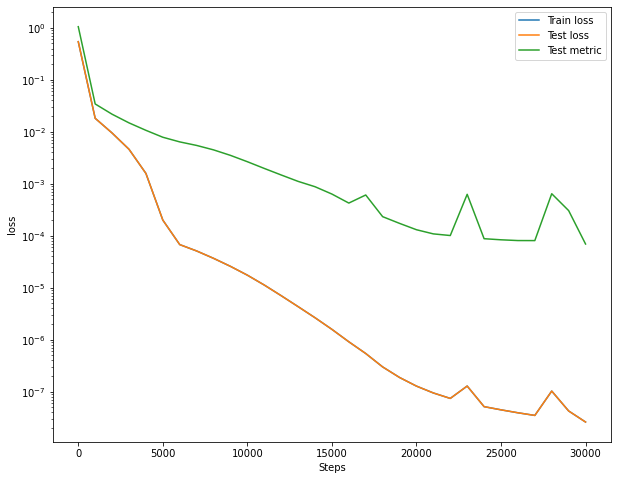

In [33]:
plot_loss_history(losshistory)

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure()
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()


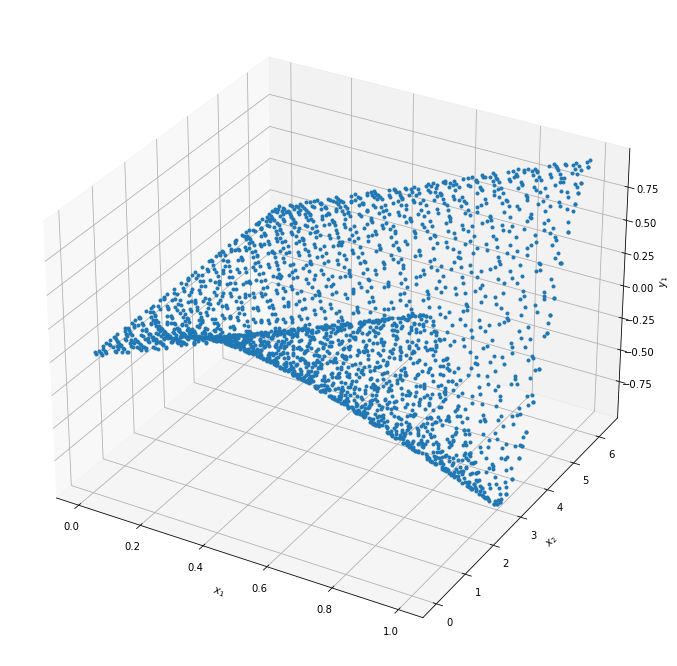

In [45]:
plot_best_state(train_state)

In [46]:
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)